In [10]:
import numpy as np
import pandas as pd
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import pickle
from scipy.linalg import svd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

In [11]:
def tokenize(data, stopwords = None):
    # Lower case
    data = data.lower()
    data = data.encode('ascii', 'ignore')

    # Punctation removal
    data = data.translate(None, string.punctuation) # changes to be done for python 3

    # Tokenization
    tokenizer = TreebankWordTokenizer()
    token_list = tokenizer.tokenize(data)

    # Removing stopwords
    if stopwords is not None:
        token_list = [word for word in token_list if word not in stopwords]

    # Stemming
#     stemmer = PorterStemmer()
#     token_list = [stemmer.stem(word) for word in token_list]
    return token_list

In [12]:
def generate_document_term_matrix(data, root_folder, data_name, stop_words, k=1000):

	print('Generating document term matrix for {0}....'.format(data_name))
	token_count_map = {}

	# vocabulary of k words based on frequency after stopword word removal, punctuation aremoval and stemming 
	for text in data.Text:
		token_list = tokenize(text, stop_words)
		for token in token_list:
			if token in token_count_map:
				token_count_map[token] = token_count_map[token] + 1
			else:
				token_count_map[token] = 1

	# sort token_count_map decreasing order of count
	sorted_item_list = sorted(token_count_map.items(), key=lambda t: t[1], reverse=True)
	vocabulary = set([x[0] for x in sorted_item_list[0:k]])

	tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, min_df=1, analyzer="word", stop_words=english_stops, vocabulary = vocabulary)
	doc_term_sparse_mat = tfidf_vectorizer.fit_transform(data.Text)

	# saving document term matrix
	with open('{0}/{1}_doc_term_matrix_{2}.pkl'.format(root_folder,data_name, k), 'wb') as fp:
		pickle.dump(doc_term_sparse_mat, fp)

	print('Finished generating document term matrix for {0}....'.format(data_name))

	return doc_term_sparse_mat, tfidf_vectorizer.vocabulary_

In [14]:
def plot_document_mat(mat , data_name, save_folder, vocab, xmin=0.4, xmax=0.8, ymin=-0.8, ymax=0.8):
    plt.figure(figsize = (12,20))
    plt.title('Data representation in reduced dimension: {0}'.format(data_name))
    plt.xlabel('dim 1')
    plt.ylabel('dim 2')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin,ymax)
    plt.grid()
    plt.plot(mat[:, :1], mat[:, 1:], 'ro')
    for i, txt in enumerate(range(mat.shape[0])):
        plt.annotate(vocab[txt], (mat[:, :1][i],mat[:, 1:][i]))
    #plt.savefig('{0}/{1}_dataplot.png'.format(save_folder, data_name))
    plt.show()

In [15]:
# main intializations
english_stops = set(stopwords.words('english'))
root_folder = '/home/vparambath/Desktop/iith/IR-Assignment2'
data_folder = '/home/vparambath/Desktop/iith/IR-Assignment2'


# Read data
data = pd.read_csv('{0}/Dataset-2.txt'.format(data_folder), sep=':', header=None, names=['TextId', 'Text'], nrows =10000)
doc_term_matrix, vocab = generate_document_term_matrix(data, root_folder, 'dataset2', english_stops)
inv_vocab = {v: k for k, v in vocab.iteritems()}

svd_5 = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd_2 = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
reduced_mat_2 = svd_2.fit_transform(doc_term_matrix.T)
reduced_mat_5 = svd_5.fit_transform(doc_term_matrix.T)

Generating document term matrix for dataset2....
Finished generating document term matrix for dataset2....


In [6]:
doc_term_matrix.T.shape

(1000, 10000)

In [34]:
#https://github.com/tirthajyoti/Interactive_Machine_Learning/blob/master/Curve_fit_widget_1.ipynb
#plot_document_mat(reduced_mat_2, 'd2', root_folder, inv_vocab)

In [41]:
def plot_document_mat(mat , data_name, save_folder, vocab):
    @interact(xmin=(0,10,0.1), xmax=(0,10,0.1), ymin=(-10,10,0.1),ymax=(-10,10,0.1))
    def plot_interact(xmin,xmax, ymin,ymax):
        plt.figure(figsize = (12,10))
        plt.title('Data representation in reduced dimension: {0}'.format(data_name))
        plt.xlabel('dim 1')
        plt.ylabel('dim 2')
        plt.xlim(xmin, xmax)
        plt.ylim(ymin,ymax)
        plt.grid()
        plt.plot(mat[:, :1], mat[:, 1:], 'ro')
        for i, txt in enumerate(range(mat.shape[0])):
            plt.annotate(vocab[txt], (mat[:, :1][i],mat[:, 1:][i]))
        #plt.savefig('{0}/{1}_dataplot.png'.format(save_folder, data_name))
        plt.show()

In [42]:
plot_document_mat(reduced_mat_2, 'd2', root_folder, inv_vocab)

interactive(children=(FloatSlider(value=5.0, description=u'xmin', max=10.0), FloatSlider(value=5.0, description=u'xmax', max=10.0), FloatSlider(value=0.0, description=u'ymin', max=10.0, min=-10.0), FloatSlider(value=0.0, description=u'ymax', max=10.0, min=-10.0), Output()), _dom_classes=('widget-interact',))

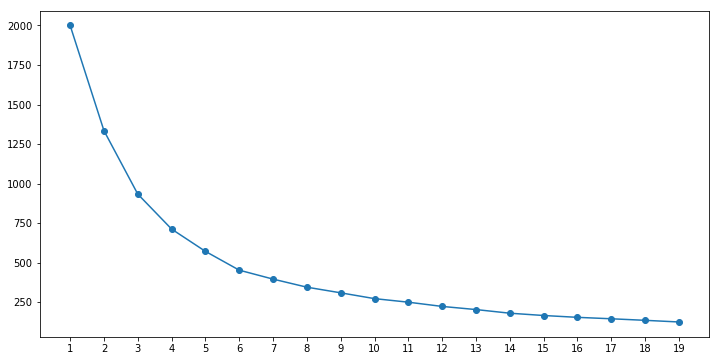

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
X_scaled = scaler.fit_transform(reduced_mat_2)

cluster_range = range( 1, 20 )
cluster_errors = []
for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( X_scaled )
    cluster_errors.append( clusters.inertia_ )
    
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
plt.figure(figsize=(12,6))
plt.plot(clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o")
plt.xticks(np.arange(1,20), np.arange(1,20))
plt.show()

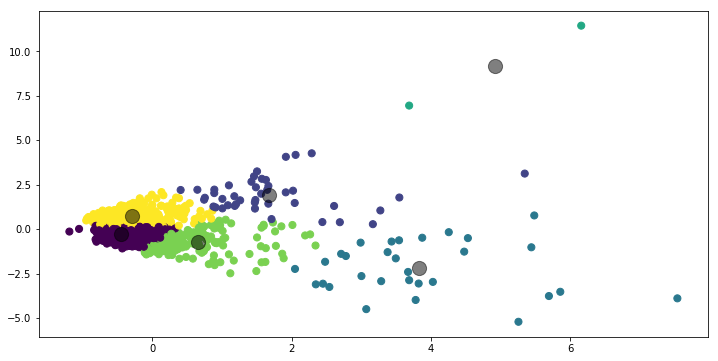

In [17]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_scaled)
y_kmeans = kmeans.predict(X_scaled)
centers = kmeans.cluster_centers_


plt.figure(figsize=(12,6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
# for i, txt in enumerate(range(X_scaled.shape[0])):
#         plt.annotate(txt, (X_scaled[:, 0][i], X_scaled[:, 1][i]))
plt.show()

In [ ]:
kmeans.labels_

In [33]:
@interact(a=None, noise_sd=(0.1,1,0.1), noise_mean=(-2,2,0.5), 
          noise_magnitude=(0,5,1), N_samples={'Low (50 samples)':50,'High (200 samples)':200},x_min=(-5,0,1), x_max=(0,5,1))
def func_gen(a, N_samples,x_min,x_max,noise_magnitude,noise_sd,noise_mean):
    x1= np.linspace(x_min,x_max,N_samples*5)
    x= np.random.choice(x1,size=N_samples)
    y=2*x-0.6*x**2+0.2*x**3+18*np.sin(x)
    y1=2*x1-0.6*x1**2+0.2*x1**3+18*np.sin(x1)
    y= y+noise_magnitude*np.random.normal(loc=noise_mean,scale=noise_sd,size=N_samples)
    plt.figure(figsize=(8,5))
    plt.plot(x1,y1,c='k',lw=2)
    plt.scatter(x,y,edgecolors='k',c='yellow',s=60)
    plt.grid(True)
    plt.show()
    return (x,y,x1,y1)

ValueError: None cannot be transformed to a widget

In [30]:
p=interactive(func_gen,a='2',N_samples={'Low (50 samples)':50,'High (200 samples)':200},x_min=(-5,0,1), x_max=(0,5,1),
              noise_magnitude=(0,5,1),noise_sd=(0.1,1,0.1),noise_mean=(-2,2,0.5))
display(p)



interactive(children=(Text(value=u'2', description=u'a'), Dropdown(description=u'N_samples', options={'Low (50 samples)': 50, 'High (200 samples)': 200}, value=50), IntSlider(value=-3, description=u'x_min', max=0, min=-5), IntSlider(value=2, description=u'x_max', max=5), IntSlider(value=2, description=u'noise_magnitude', max=5), FloatSlider(value=0.5, description=u'noise_sd', max=1.0, min=0.1), FloatSlider(value=0.0, description=u'noise_mean', max=2.0, min=-2.0, step=0.5), Output()), _dom_classes=('widget-interact',))